## Work flow for single cell tracing analysis

1. Convert annotations to um units
2. (V3d) Resample in 1um steps
3. Downsample to 25ums, will also generate indices for endings
4. (Console) Transform points according to how the sample was aligned to template (run Transform_points.py under elastix directory)
5. Identify points in the corresponding atlas
6. Make tiff stack with points only, in full z sections (functional for sample imaged in coronal plane, 

WIP for samples in horizontal consider that both AP and DV planes were cut...)


### update august 2021 for anatomy MS

to generate tiff stacks for axons and dendrite as well as region with counts in excel files

In [1]:
import os
import tkinter.filedialog as fdialog
import Neuron_analysis as na
from Neuron_analysis import *
import numpy as np

import pandas as pd
import SimpleITK as sitk


In [2]:
na.points.convert_anno()
# repeat for both axons and dendrites

AttributeError: 'NoneType' object has no attribute 'name'

#### Now, go to v3d and resample these files in 1um steps
Under vaa3d plugin- resample. Repeat for both axons and dendrites

Then come back and proceed to next step

In [4]:
na.points.downsample_anno()
# repeat for both axons and dendrites

Resampled annotation step size is 1 um in x y z. downsampling to 25 um. dowmsample ratio is 25.0.


Press Enter to continue... 


AL131_25voxel_trace_1umStepsize.txt
Downsampling annotation done.


#### For sample2ara
to console and transform these points
use Transform_points.py

## two methods converge for the section below

In [2]:
in_dir = fdialog.askdirectory(title='Please select the input directory')
# ie: D:\2PT electroporation time\AL066
axon= fdialog.askopenfilename(title='Selecte the transformed points for axons')
dendrite= fdialog.askopenfilename(title='Selecte the transformed points for dendrites')

In [38]:
# files= os.listdir(in_dir)
# ending_files= [os.path.join(in_dir,i) for i in files if '_endings' in i]
# axon_ending= [i for i in ending_files if 'D_' not in i][0]
# dendrite_ending=[i for i in ending_files if 'D_' in i][0]


In [3]:
out_dir='D:/Complete_points/'
mouse_name=na.find_mousename(in_dir)
out_name=out_dir+mouse_name

### old section

mostly for sample 2ara files

In [6]:
points,atlas_name=na.get_pt_natlas(file_type,in_dir,full=False)
# reads in the points and get the corresponding atlas(cropped version cus we need to extract the cropped plane from its name)
na.find_crop(atlas_name)
# extract the cropped sections ie. section 100-394
points_full=na.points.refill_section(points,atlas_name)
# fills in the missing section by adding the leading slice to the z coordinates of the downsampled points
na.atlas.make_tif(points_full, na.fullatlas_name,out_dir+mouse_name, is_axon)
# projects the downsampled points(now in full z plane) to a tiff file, now ready to merge with the complete atlas and template

Starting to saving tif files..


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/Complete_points/AL175_axons.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [13]:
region_counts, points_in_atlas=na.points.make_pd(points_full,file_ending,out_name,is_axon)
# find the corresponding atlas ID for each point, store in pd datafile with counts for main and ends
# also outputs an excel file
na.points.make_point_csv(points_full, points_in_atlas,out_name,is_axon)
# outputs a csv file with downsampled points and their associated id

In [14]:
na.points.check_points(points_in_atlas)
# check for IDs that are without atlas label

In [15]:
points_original= fdialog.askopenfilename(title='Selecte the original resampled points')
# asks for the non-downsampled annotation, usually the eswc file that has been converted to um and resampled at 1 um steps
# typically in petersen server analysis folder

original_withID=na.points.findID_origional(points_original, points_in_atlas,out_name,is_axon)
#makes a csv file with original points and their associated id


In [89]:
na.whatis()

what is it that you look for? 484682528


Atlas id= 529    484682528
Name: id, dtype: int64
Name= 529    commissural branch of stria terminalis
Name: safe_name, dtype: object
Hemisphere= 529    3
Name: hemisphere_id, dtype: int64


In [23]:
points,atlas_name=na.get_pt_natlas(file_type,in_dir,full=False)


In [26]:
na.find_crop(atlas_name)


TypeError: 'NoneType' object is not subscriptable

## update aug 2021 for anatomy MS
## for ara2sample 

In [4]:
##useful functions

def check_points(points_in_atlas):
    '''Checks whether all your points' ID is within the atlas labels
    Input: matching ID of the points (this is the second output from na.make_pd)
    '''
    id_inatlas=[]
    for x in atlas_labels['region_id']:
        intID = int(x)
        id_inatlas.append(intID)

    # need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

    num_of_zeros = [i for i, x in enumerate(points_in_atlas) if x == 0]
    # find the indices for which carries an id =0
    
    unique_id=set(points_in_atlas)
    
    for id_inbrain in unique_id:
        if id_inbrain not in id_inatlas:
            if id_inbrain==0:
                print(f'There are {len(num_of_zeros)} points with ID= {id_inbrain}, this index is outside of the brain, consider possible suboptimal image registration')
            else: 
                print(id_inbrain,'this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37')
            warnings.warn('Some points do not have corresponding labels')
    return 


In [7]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\wraped\ccf_2017_itksnap_labels.csv', sep=',')


In [6]:
is_axon=1

if is_axon==1:
    file_type=axon
elif is_axon==0:
    file_type=dendrite
# put 0 if working with dendrites

In [7]:
points,atlas_name=na.get_pt_natlas(file_type,in_dir)
# read points and get path name of the corresponding atlas

In [8]:
atlas_name

'D:/2PT electroporation time/AL092/ara2sample_atlas/result.mhd'

In [73]:
if is_axon :
    na.atlas.make_tif_1(points, atlas_name,out_dir+mouse_name, is_axon)
else:
    na.atlas.make_tif(points, atlas_name,out_dir+mouse_name, is_axon)
# save points as a tiff file for visualization and overlay
# for dendrites, keep the intensities different since...its too cramped up and will look bad!

Starting to saving tif files..


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/Complete_points/AL140_axons.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [9]:
points_in_atlas= na.points.find_point_id(points,atlas_name)
# find id of points in corresponding atlas

In [10]:
check_points(points_in_atlas)
#we should only see id=0 as possibility now since now is using the itksnap_wraped atlas

There are 36 points with ID= 0, this index is outside of the brain, consider possible suboptimal image registration


NameError: name 'warnings' is not defined

In [12]:
points_in_atlas= np.where(points_in_atlas==0, 844, points_in_atlas) 
# replace id= 0 with 844 (ssp-bfd layer1)

if is_axon :
    points_in_atlas= np.where(points_in_atlas==800 , 215 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==1092 , 215 , points_in_atlas)
    # replace id= 800 (subependymal zone) and 1092 (lateral ventricle) with 215(caudoputamen)
    # especially for AL131
    
    points_in_atlas= np.where(points_in_atlas==1242, 1296 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==1127, 1296 , points_in_atlas)
    # replace id= 1242 (optic radiation)  and id= 1127 (auditory radiation) with 1296, stc(a subregion of fiber bundle)
    # these are intrinsic issue of the allen atlas, the lavels for these regions are wrong

check_points(points_in_atlas)
# check again to see if 0 disappears

In [ ]:
region_counts=na.points.make_pd_ara2sample(points_in_atlas.tolist(),atlas_labels,out_name,is_axon)

In [32]:
na.atlas_labels

,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,...,graph_order,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name
0,1000,690.0,extrapyramidal fiber systems,eps,2,1,3,8690,1009.0,2,...,1218,/997/1009/1000/,CCCCCC,NaN,NaN,f,1219,738013408,734881840,extrapyramidal fiber systems
1,223,27.0,Arcuate hypothalamic nucleus,ARH,8,1,3,8690,157.0,6,...,733,/997/8/343/1129/1097/157/223/,FF5D50,NaN,NaN,f,734,218062747,734881840,Arcuate hypothalamic nucleus
2,12998,NaN,"Somatosensory areas, layer 6b",SS6b,11,1,3,8690,453.0,7,...,36,/997/8/567/688/695/315/453/12998/,188064,NaN,NaN,f,37,3017218874,734881840,Somatosensory areas layer 6b
3,163,1010.0,"Agranular insular area, posterior part, layer 2/3",AIp2/3,11,1,3,8690,111.0,8,...,287,/997/8/567/688/695/315/95/111/163/,219866,NaN,NaN,f,288,2735510231,734881840,Agranular insular area posterior part layer 2/3
4,552,917.0,"Pontine reticular nucleus, ventral part",PRNv,8,1,3,8690,987.0,6,...,914,/997/8/343/1065/771/987/552/,FFBA86,NaN,NaN,f,915,3053786086,734881840,Pontine reticular nucleus ventral part
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,324,1030.0,"Entorhinal area, medial part, ventral zone, la...",ENTmv2,11,1,3,8690,934.0,9,...,519,/997/8/567/688/695/1089/822/909/934/324/,32B825,NaN,NaN,f,520,465925972,734881840,Entorhinal area medial part ventral zone layer 2
1323,321,464.0,Subgeniculate nucleus,SubG,8,1,3,8690,1014.0,7,...,710,/997/8/343/1129/549/856/1014/321/,FF909F,NaN,NaN,f,711,3545734096,734881840,Subgeniculate nucleus
1324,796,806.0,Dopaminergic A13 group,A13,9,1,3,8690,797.0,7,...,803,/997/8/343/1129/1097/290/797/796/,F2483B,NaN,NaN,f,804,4064653384,734881840,Dopaminergic A13 group
1325,436,478.0,columns of the fornix,fx,10,1,3,8690,737.0,6,...,1252,/997/1009/991/768/1099/737/436/,CCCCCC,NaN,NaN,f,1253,2234311931,734881840,columns of the fornix


## Optional

In [13]:
points_original= fdialog.askopenfilename(title='Selecte the original resampled points')
# asks for the non-downsampled annotation, usually the eswc file that has been converted to um and resampled at 1 um steps
# typically in petersen server analysis folder

original_withID=na.points.findID_origional(points_original, points_in_atlas,out_name,is_axon)
#makes a csv file with original points and their associated id

In [72]:
original_withID

,x,y,z,atlasID
0,3427.11,2251.2,4225.56,845
1,3427.13,2250.8,4226.47,845
2,3427.15,2250.4,4227.39,845
3,3427.17,2250.01,4228.31,845
4,3427.2,2249.61,4229.22,844
...,...,...,...,...
69429,4169.03,2465.77,5265.7,890
69430,4168.61,2465.45,5265,890
69431,4167.83,2464.83,5265,890
69432,4176.18,2535.2,5320,890


## Start here for grey vs white

In [2]:
import matplotlib.pyplot as plt
import tkinter.filedialog as fdialog

import math


In [3]:
out_dir='M:\\analysis\Yanqi_Liu\\For_anatomy_manuscript\\Figures\\For_reviewers\\'


In [4]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\wraped\ccf_2017_itksnap_labels.csv', sep=',')


In [40]:
ori_pointsID= fdialog.askopenfilename(title='Selecte the original resampled points with ID excel file')
mouse_name= na.find_mousename(ori_pointsID)
out_name=out_dir+mouse_name
mouse_name

'AL080'

In [41]:
original_withID= pd.read_csv (ori_pointsID)
original_withID.head()

,x,y,z,atlasID
0,11204.0,2307.20,1745.00,1053
1,11204.3,2307.25,1745.95,1053
2,11204.6,2307.31,1746.91,1053
3,11204.6,2307.39,1747.91,1053
4,11204.7,2307.47,1748.90,1053


In [42]:
full_label=pd.merge(na.atlas_labels, atlas_labels, on = 'acronym')

In [43]:
fiber_tracts=full_label[full_label['structure_id_path'].str.contains("1009")].region_id
fiber_tracts=fiber_tracts.tolist()

In [44]:
striatum=full_label[full_label['structure_id_path'].str.contains("477")].region_id
striatum=striatum.tolist()

In [45]:
white=original_withID.loc[original_withID['atlasID'].isin(fiber_tracts)]
grey=original_withID.loc[~original_withID['atlasID'].isin(fiber_tracts) & ~original_withID['atlasID'].isin(striatum)]
stri=original_withID.loc[original_withID['atlasID'].isin(striatum)]

In [46]:
white.empty

False

In [47]:
grey.empty

False

In [48]:
stri.empty

True

In [49]:
xg= pd.to_numeric(grey['x']).round()
yg= pd.to_numeric(grey['y']).round()
zg= pd.to_numeric(grey['z']).round()

xw= pd.to_numeric(white['x']).round()
yw= pd.to_numeric(white['y']).round()
zw= pd.to_numeric(white['z']).round()

xs= pd.to_numeric(stri['x']).round()
ys= pd.to_numeric(stri['y']).round()
zs= pd.to_numeric(stri['z']).round()

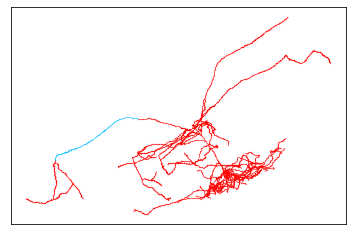

In [50]:
plt.scatter(xg[::5], yg[::5],s=0.01, c='red')
plt.scatter(xw[::5], yw[::5], s= 0.01, c= 'deepskyblue')
plt.scatter(xs[::5], ys[::5], s= 0.01, c= 'lime')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig(out_name+"_c_axons.svg", format='svg')

plt.show()

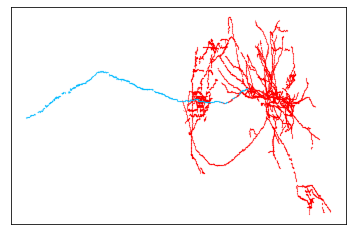

In [21]:
plt.scatter(xg[::5], zg[::5],s=0.01, c='red')
plt.scatter(xw[::5], zw[::5], s= 0.01, c= 'deepskyblue')
plt.scatter(xs[::5], zs[::5], s= 0.01, c= 'lime')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig(out_name+"_h_axons.svg", format='svg')
plt.show()
#horizontal view

In [51]:
def rotate(x,y,xo,yo,degrees): #rotate x,y around xo,yo by x degrees
    theta = np.deg2rad(degrees) # convert degrees to rad
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)  + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    return [xr,yr]

In [52]:
# note that for AL 066, 092 and 080, the rotation angle is -30, due to the orientation how the brain is imaged
# for all other brains in anatomy MS 2021, rotation angle is 30 degrees
list_xy= list(zip(xg,yg))
list_xy[1]
rot_xg=[]
rot_yg=[]
for i in list_xy:
    x= i[0]
    y= i[1]
    newx,newy= rotate(x,y,0,0,-30)
    rot_xg.append(newx)
    rot_yg.append(newy)

list_xy= []

In [53]:
if xw.empty:
    rot_xw=[]
    rot_yw=[]
else: 
    list_xy= list(zip(xw,yw))
    list_xy[1]
    rot_xw=[]
    rot_yw=[]
    for i in list_xy:
        x= i[0]
        y= i[1]
        newx,newy= rotate(x,y,0,0,-30)
        rot_xw.append(newx)
        rot_yw.append(newy)

    list_xy= []

In [54]:
if xs.empty:
    rot_xs=[]
    rot_ys=[]
else:
    list_xy= list(zip(xs,ys))
    list_xy[1]
    rot_xs=[]
    rot_ys=[]
    for i in list_xy:
        x= i[0]
        y= i[1]
        newx,newy= rotate(x,y,0,0,-30)
        rot_xs.append(newx)
        rot_ys.append(newy)

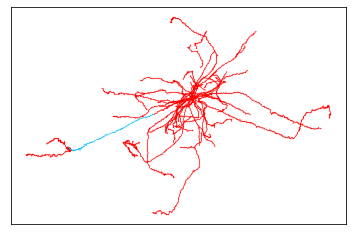

In [55]:
plt.scatter(rot_xg[::5], zg[::5],s=0.01, c='red')
plt.scatter(rot_xw[::5], zw[::5], s= 0.01, c= 'deepskyblue')
plt.scatter(rot_xs[::5], zs[::5], s= 0.01, c= 'lime')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig(out_name+"_bf_axons.svg", format='svg')
plt.show()